In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
plt.rcParams["font.family"] = "Arial"
plt.rcParams["pdf.fonttype"] = 42

In [3]:
base_data_path = Path("outputs/datapts_force_slope")
df = pd.DataFrame(
    [
        (*map(int, i.stem.split("_")[1::2]), i)
        for i in sorted(base_data_path.glob("*.npz"))
    ],
    columns=["force", "slope", "seed", "path"],
)

In [4]:
forces = []
seeds = []
critical_slopes = []
reached_end_all = []
reached_end_critical = []

is_critical = True
x_pos_thr = -6  # two body lengths

metadata = {
    "run_time": 0.7,
    "stabilisation_dur": 0,
    "timestep": 1e-4,
    "slope_reversal_time": 0.2,
}

# Go through all pkl files
for (force, seed), df_ in df.groupby(["force", "seed"]):
    forces.append(force)
    seeds.append(seed)
    df_ = df_.sort_values("slope")

    for i in df_.itertuples():
        obs_fly = np.load(i.path)["fly"]
        # Check if the end was reached
        is_complete = len(obs_fly) == np.ceil(
            (metadata["run_time"] + metadata["stabilisation_dur"])
            / metadata["timestep"]
        )
        reached_end_all.append(is_complete)

        if len(forces) == len(critical_slopes):
            # print(force_folder.name, slope_file.name, "already processed")
            continue

        # When gravity is reversed, xpos is not zeros
        # check wether the x pos is threshold away from the position it was when gravity was reversed
        # In case something went wrong, check if the fly was flipped (maybe with low slopes, the fly flips over but does not go reverse x due to friciton)

        reverse_id = int(
            np.ceil(metadata["slope_reversal_time"] / metadata["timestep"])
        )

        fly_xvel = obs_fly[:, 1, 2]
        fly_xpos = obs_fly[:, 0, 0]
        fly_xpos_treverse_is_origin = fly_xpos[reverse_id:] - fly_xpos[reverse_id]
        is_critical = np.any(fly_xpos_treverse_is_origin < x_pos_thr)
        if not is_critical:
            # check wether the fly just flipped over
            fly_ang = obs_fly[:, 2, 1:]
            is_critical = np.any(np.abs(fly_ang) > np.pi / 2)
            if is_critical:
                print("Fly flipped over")
        if is_critical:
            critical_slopes.append(i.slope)
            reached_end_critical.append(is_complete)
            # DO NOT BREAK JUST TO CHECK IF SOME SIMULATION DID NOT REACH THE END

print(forces, critical_slopes, reached_end_critical)

ids_reached_end = np.where(reached_end_critical)[0]
ids_did_not_reach_end = np.where(np.logical_not(reached_end_critical))[0]

Fly flipped over
Fly flipped over
Fly flipped over
Fly flipped over
Fly flipped over
[0, 0, 0, 0, 0, 5, 5, 5, 5, 5, 10, 10, 10, 10, 10, 15, 15, 15, 15, 15, 20, 20, 20, 20, 20, 25, 25, 25, 25, 25, 30, 30, 30, 30, 30, 35, 35, 35, 35, 35, 40, 40, 40, 40, 40, 45, 45, 45, 45, 45, 50, 50, 50, 50, 50, 55, 55, 55, 55, 55, 60, 60, 60, 60, 60] [30, 30, 30, 30, 30, 35, 35, 35, 35, 35, 40, 40, 40, 40, 40, 50, 50, 55, 60, 60, 80, 60, 60, 70, 60, 75, 70, 100, 90, 95, 105, 60, 70, 75, 110, 80, 85, 105, 105, 45, 105, 80, 110, 95, 65, 100, 100, 65, 50, 115, 100, 105, 80, 80, 85, 80, 100, 95, 105, 100, 95, 55, 110, 65, 80] [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, F

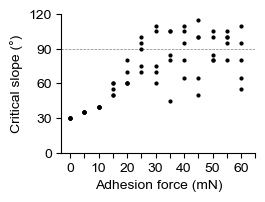

In [5]:
fig, ax = plt.subplots(figsize=(2.5, 1.8))
scatter = ax.scatter(forces, critical_slopes, s=4, c="k")
ax.set_xlabel("Adhesion force (mN)")
ax.set_ylabel("Critical slope (°)")
ax.axhline(90, color="gray", linestyle="--", linewidth=0.5, zorder=-1)
ax.set_yticks([0, 15, 30, 45, 60, 75, 90, 105, 120][::2])
xticks = np.arange(0, 70, 5)
xticklabels = [f"{x}" if x % 10 == 0 else "" for x in xticks]
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
fig.savefig(
    "outputs/critical_slope.pdf", transparent=True, bbox_inches="tight", pad_inches=0
)

In [6]:
pd.DataFrame({"adhesion_force": forces, "critical_slope": critical_slopes}).to_csv("outputs/critical_slope.csv", index=False)